# Testing the CER Prediction Model on the FRUS and UN corpuses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pymysql

In [28]:
from joblib import Parallel, delayed
import joblib
import os

In [16]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pymysql

Note: you may need to restart the kernel to use updated packages.


Load in the model for prediction.

In [2]:
from predict_cer import load_pipeline, extract_features_from_text, load_expected_frequencies

Load in the FRUS document bodies.

In [4]:
query = 'select id, raw_body from docs;'
conn = pymysql.connect(host='history-lab.org', user='de_reader', password='XreadF403', db='declassification_frus')
cursor = conn.cursor()
cursor.execute(query)
doc = cursor.fetchall()
cursor.close(),
conn.close()

Preview.

In [8]:
print(doc[10])

('frus1865p4d1007', '  \nFrom the state chancery of the federal state of Zurich to the committee for the address of sympathy and condolence to the American Union in Berne.\n\nHonored Sir: We have the honor, by order of our state council, in answer to your esteemed letter of the 1st instant, to communicate to the authorities inviting our participation in the address of sympathy and condolence to the American Union, that our state council expresses the friendly feeling it has for the late successes of the Union in its war for freedom, and the deep sorrow for the atrocious assassination of its excellent President, Mr. Abraham Lincoln, and makes this known to the federal council for its proper communication to the authorities in the United States of America.\nAccept, sir, the assurance of our distinguished consideration.\nThe slate chancery of the canton of Zurich, by the second secretary of state,\n\nT. BOKHARD.\n\n')


In [7]:
print(len(doc))

209046


Make predictions.

In [10]:
def load_pipeline():
    return joblib.load('model.pkl')

In [21]:
def predict_cer_for_docs(doc):
    results = []
    pipeline = load_pipeline('model.pkl')
    expected_frequencies = load_expected_frequencies('expected_letter_distribution.csv')

    for doc_id, text in doc:
        try:
            features = extract_features_from_text(text, expected_frequencies)
            features_df = pd.DataFrame([features])
            predicted_cer = pipeline.predict(features_df)[0]
            results.append({'doc_id': doc_id, 'predicted_cer': predicted_cer})
        except ZeroDivisionError:
            print(f"Warning: Division by zero encountered in document {doc_id}. Skipping this document.")

    return results

def main():
    predictions = predict_cer_for_docs(doc)
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv('frus_cer_predictions.csv', index=False)
    print("Predicted CER results saved to 'frus_cer_predictions.csv'")

In [22]:
if __name__ == '__main__':
    main()

In [29]:
pipeline = load_pipeline()
expected_frequencies = load_expected_frequencies('expected_letter_distribution.csv')

def predict_cer(doc_id, text):
    try:
        features = extract_features_from_text(text, expected_frequencies)
        features_df = pd.DataFrame([features])
        predicted_cer = pipeline.predict(features_df)[0]
        return {'doc_id': doc_id, 'predicted_cer': predicted_cer}
    except ZeroDivisionError:
        print(f"Warning: Division by zero encountered in document {doc_id}. Skipping this document.")
        return None

def predict_cer_for_docs(docs):
    results = Parallel(n_jobs=-1)(delayed(predict_cer)(doc_id, text) for doc_id, text in docs if text is not None)
    return [result for result in results if result is not None]

def main(docs, start_index=0, end_index=None):
    # if end_index is None, process all documents up to the end of the list
    if end_index is None:
        end_index = len(docs)
    
    # slice the docs from the start_index to the end_index
    docs_to_process = docs[start_index:end_index]
    predictions = predict_cer_for_docs(docs_to_process)
    predictions_df = pd.DataFrame(predictions)
    
    # determine if the file needs the header (only if start_index is 0 and the file doesn't exist)
    file_exists = os.path.exists('frus_cer_predictions.csv')
    write_header = not file_exists or start_index == 0

    predictions_df.to_csv('frus_cer_predictions.csv', mode='a', header=write_header, index=False)
    print(f"Predicted CER results saved to 'frus_cer_predictions.csv' from document {start_index} to {end_index}")

In [56]:
if __name__ == '__main__':
    main(doc, start_index=0, end_index=50000)

Predicted CER results saved to 'frus_cer_predictions.csv' from document 20000 to 50000


In [60]:
frus_predictions = pd.read_csv('frus_cer_predictions.csv')

In [58]:
frus_predictions

,doc_id,predicted_cer
0,frus1865p4d1,0.050489
1,frus1865p4d10,0.102168
2,frus1865p4d100,0.207765
3,frus1865p4d1000,0.193504
4,frus1865p4d1001,0.197256
...,...,...
49995,frus1941v05d530,0.069841
49996,frus1941v05d531,0.095733
49997,frus1941v05d532,-0.005621
49998,frus1941v05d533,0.017370


In [37]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
frus_predictions.describe()

,predicted_cer
count,50000.000000
mean,0.091280
std,0.089859
min,-0.101769
25%,0.031967
50%,0.074075
75%,0.129589
max,1.861013


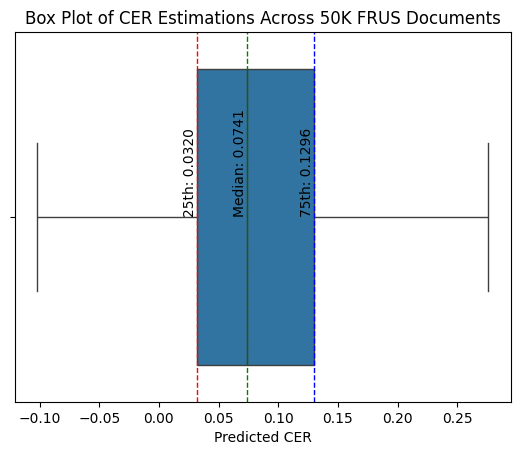

In [63]:
sns.boxplot(x='predicted_cer', data=frus_predictions, showfliers=False)  # 'showfliers=False' removes outliers

plt.title('Box Plot of CER Estimations Across 50K FRUS Documents')
plt.xlabel('Predicted CER')

# Calculating quartiles
q25 = frus_predictions['predicted_cer'].quantile(0.25)
q50 = frus_predictions['predicted_cer'].quantile(0.50)
q75 = frus_predictions['predicted_cer'].quantile(0.75)

# Adding quartile labels with actual values
plt.axvline(q25, color='r', linestyle='dashed', linewidth=1)
plt.axvline(q50, color='g', linestyle='dashed', linewidth=1)
plt.axvline(q75, color='b', linestyle='dashed', linewidth=1)

plt.text(q25, 0, f'25th: {q25:.4f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(q50, 0, f'Median: {q50:.4f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='black')
plt.text(q75, 0, f'75th: {q75:.4f}', rotation=90, verticalalignment='bottom', horizontalalignment='right', color='black')

plt.show()

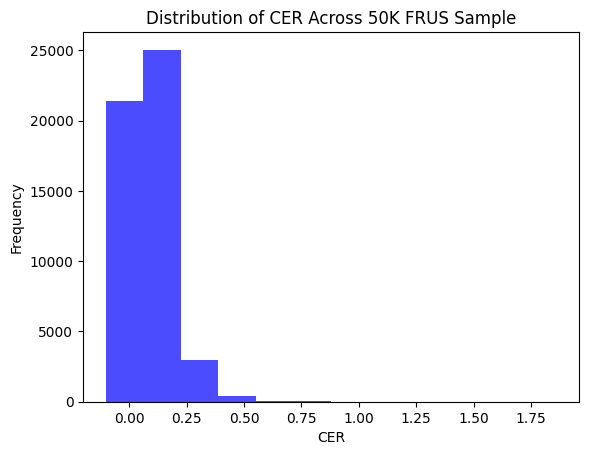

In [64]:
plt.hist(frus_predictions['predicted_cer'], bins=12, color='blue', alpha=0.7)
plt.title('Distribution of CER Across 50K FRUS Sample')
plt.xlabel('CER')
plt.ylabel('Frequency')
plt.show()